# Library Import

In [4]:
import numpy as np
import pandas as pd 
import os

import matplotlib.pyplot as plt 

In [5]:
import torch
import numpy as np
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Recommended for full determinism
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [6]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

CUDA Available: True
GPU Name: NVIDIA GeForce GTX 1660 Ti with Max-Q Design


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Load 


In [8]:
# dir= "D:/Coding Projects/GitHub Projects/metal-surface-defect-classification/"

In [9]:
train_dir = 'D:/Coding Projects/GitHub Projects/metal-surface-defect-classification/data/raw/train'
print("Train Direcorty: ",os.listdir(train_dir))
test_dir = 'D:/Coding Projects/GitHub Projects/metal-surface-defect-classification/data/raw/test'
print("test Direcorty: ",os.listdir(test_dir))
val_dir = 'D:/Coding Projects/GitHub Projects/metal-surface-defect-classification/data/raw/valid'
print("val Direcorty: ",os.listdir(val_dir))

Train Direcorty:  ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']
test Direcorty:  ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']
val Direcorty:  ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']


# Custom Data Loader

In [10]:
import os
from torch.utils.data import Dataset
from PIL import Image

class MetalSurfaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        root_dir -> path to the train folder
        train/ 
            Crazing/
            Inclusion/
            ...
        """

        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {} # mapping class names to integers

        # Step 1 : Create class index mapping
        classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

        # Step 2 : iterate through each class folder
        for cls_name in classes:
            cls_folder = os.path.join(root_dir,cls_name)
            label = self.class_to_idx[cls_name]

            # Step 3 : Iterate thrugh each image in one class folder
            for file_name in sorted(os.listdir(cls_folder)):
                file_path = os.path.join(cls_folder, file_name)
                
                # Append image path and corresponding label
                self.image_paths.append(file_path)
                self.labels.append(label)
     
    def __len__(self):
        """ Return total count of images. """
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Getting a sample image 
        """
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image
        img = Image.open(img_path).convert("RGB")

        # Apply transforms (resize, normalize, etc.)
        if self.transform:
            img = self.transform(img)

        return img, label

 Defining Data preprocessing

In [11]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean= [0.485,0.456, 0.406],
        std= [0.229,0.224,0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [12]:
train_dataset = MetalSurfaceDataset(
    root_dir= train_dir,
    transform= train_transform
)

val_dataset = MetalSurfaceDataset(
    root_dir= val_dir,
    transform= val_transform
)

test_dataset = MetalSurfaceDataset(
    root_dir= test_dir,
    transform= test_transform
)

In [13]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size= 32,
    shuffle= True,
    num_workers= 0,
    pin_memory= True
)

val_loader = DataLoader(
    val_dataset,
    batch_size= 32,
    shuffle= False,
    num_workers= 0,
    pin_memory= True
)

test_loader = DataLoader(
    test_dataset,
    batch_size= 32,
    shuffle= False,
    num_workers= 0,
    pin_memory= True
)

In [14]:
print(f"Total Number of Train Images : {train_dataset.__len__()}")
print(f"Total Number of Validation Images : {val_dataset.__len__()}")
print(f"Total Number of Test Images : {test_dataset.__len__()}")

Total Number of Train Images : 1656
Total Number of Validation Images : 72
Total Number of Test Images : 72


In [15]:
def show_tensor_image(tensor, title=""):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])

    img = tensor * std[:, None, None] + mean[:, None, None]
    img = img.permute(1, 2, 0).clamp(0, 1)

    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

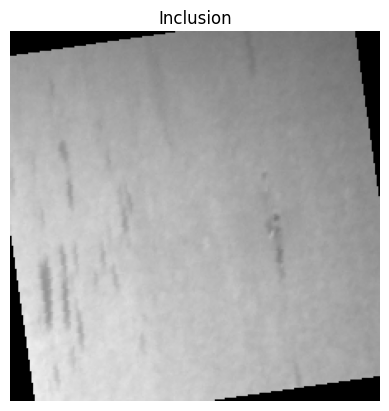

In [16]:
sample_number = 400

idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

image, label = train_dataset.__getitem__(sample_number)

show_tensor_image(image, idx_to_class[label])

# Model Definition

In [35]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes= 6):
        super(CustomCNN, self).__init__()

        # Feature Extractor
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels= 6, kernel_size= 3, stride= 1, padding= 1), # out : 32x224x224
            nn.ReLU(),
            nn.MaxPool2d(2),                                                                   # out : 32x112x112         

            nn.Conv2d(in_channels=6, out_channels= 12, kernel_size= 3, stride= 1, padding= 1), # out : 64x112x112
            nn.ReLU(),
            nn.MaxPool2d(2),                                                                   # out : 64x56x56

            nn.Conv2d(in_channels=12, out_channels= 24, kernel_size= 3, stride= 1, padding= 1), # out : 128x56x56
            nn.ReLU(),
            nn.MaxPool2d(2),                                                                   # out : 128x28x28
        )

        # Fully Connected layer
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(24*28*28, 16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(16, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x

In [36]:
from torchsummary import summary

temp_model = CustomCNN(num_classes= 6).to(device)
summary(temp_model, input_size= (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 224, 224]             168
              ReLU-2          [-1, 6, 224, 224]               0
         MaxPool2d-3          [-1, 6, 112, 112]               0
            Conv2d-4         [-1, 12, 112, 112]             660
              ReLU-5         [-1, 12, 112, 112]               0
         MaxPool2d-6           [-1, 12, 56, 56]               0
            Conv2d-7           [-1, 24, 56, 56]           2,616
              ReLU-8           [-1, 24, 56, 56]               0
         MaxPool2d-9           [-1, 24, 28, 28]               0
          Flatten-10                [-1, 18816]               0
           Linear-11                   [-1, 16]         301,072
             ReLU-12                   [-1, 16]               0
          Dropout-13                   [-1, 16]               0
           Linear-14                   

# Model Training

In [37]:
import torch.optim as optim
from tqdm import tqdm

In [38]:
model = CustomCNN(num_classes= 6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 1e-3)

# Adding Learning Rate Schduler for stable learning
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [39]:
num_epochs = 100
best_val_acc = 0

best_val_loss = float('inf')
patience = 10
patience_counter = 0

train_losses_list = []
val_losses_list = []
train_accs_list = []
val_accs_list = []

for epoch in range(num_epochs):
    # --------------------------------------------------------
    # Training Mode
    # --------------------------------------------------------
    # Setting Model to Training Mode
    model.train()
    
    train_loss = 0
    train_correct = 0
    train_total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    train_epoch_loss = train_loss / len(train_dataset)
    train_epoch_acc = train_correct / train_total 

    # --------------------------------------------------------
    # Validation Mode
    # --------------------------------------------------------
    # Setting Model to val Mode
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            val_correct += (predicted==labels).sum().item()
            val_total += labels.size(0)

    val_epoch_loss = val_loss / len(val_dataset)
    val_epoch_acc = val_correct / val_total

    # Schduler step
    scheduler.step()

    # Print everything
    print(f"------------------------------------------------------------------------------------------------")   
    print(f"Epoch {epoch+1} / {num_epochs} | Train_Loss : {train_epoch_loss:.3f} | Train_Accuracy : {train_epoch_acc:.3f}")
    print(f"Epoch {epoch+1} / {num_epochs} | Val_Loss : {val_epoch_loss:.3f} | Val_Accuracy : {val_epoch_acc:.3f}")
   
    # Model Checkpointing : Saving best model 
    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        torch.save(model.state_dict(), "D:/Coding Projects/GitHub Projects/metal-surface-defect-classification/models/model.pth")
        print("Saved best Model")

    print(f"------------------------------------------------------------------------------------------------")

    # Saving the train and validation acc and loss values for plotting
    train_losses_list.append(train_epoch_loss)
    val_losses_list.append(val_epoch_loss)
    
    train_accs_list.append(train_epoch_acc)
    val_accs_list.append(val_epoch_acc)

    # Early Stopping Check :
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"No Improvements in val_loss | Patience Counter {patience_counter} / {patience}")
        if patience_counter == patience :
            print("🔥 Early stopping triggered! ")
            break

Epoch 1/100: 100%|██████████| 52/52 [00:07<00:00,  7.03it/s]


------------------------------------------------------------------------------------------------
Epoch 1 / 100 | Train_Loss : 1.642 | Train_Accuracy : 0.322
Epoch 1 / 100 | Val_Loss : 1.347 | Val_Accuracy : 0.472
Saved best Model
------------------------------------------------------------------------------------------------


Epoch 2/100: 100%|██████████| 52/52 [00:07<00:00,  7.40it/s]


------------------------------------------------------------------------------------------------
Epoch 2 / 100 | Train_Loss : 1.305 | Train_Accuracy : 0.459
Epoch 2 / 100 | Val_Loss : 0.899 | Val_Accuracy : 0.694
Saved best Model
------------------------------------------------------------------------------------------------


Epoch 3/100: 100%|██████████| 52/52 [00:07<00:00,  7.17it/s]


------------------------------------------------------------------------------------------------
Epoch 3 / 100 | Train_Loss : 1.076 | Train_Accuracy : 0.546
Epoch 3 / 100 | Val_Loss : 0.741 | Val_Accuracy : 0.722
Saved best Model
------------------------------------------------------------------------------------------------


Epoch 4/100: 100%|██████████| 52/52 [00:06<00:00,  7.60it/s]


------------------------------------------------------------------------------------------------
Epoch 4 / 100 | Train_Loss : 1.049 | Train_Accuracy : 0.547
Epoch 4 / 100 | Val_Loss : 0.787 | Val_Accuracy : 0.694
------------------------------------------------------------------------------------------------
No Improvements in val_loss 1 / 10


Epoch 5/100: 100%|██████████| 52/52 [00:07<00:00,  7.27it/s]


------------------------------------------------------------------------------------------------
Epoch 5 / 100 | Train_Loss : 0.948 | Train_Accuracy : 0.576
Epoch 5 / 100 | Val_Loss : 0.528 | Val_Accuracy : 0.833
Saved best Model
------------------------------------------------------------------------------------------------


Epoch 6/100: 100%|██████████| 52/52 [00:07<00:00,  7.20it/s]


------------------------------------------------------------------------------------------------
Epoch 6 / 100 | Train_Loss : 0.882 | Train_Accuracy : 0.643
Epoch 6 / 100 | Val_Loss : 0.472 | Val_Accuracy : 0.889
Saved best Model
------------------------------------------------------------------------------------------------


Epoch 7/100: 100%|██████████| 52/52 [00:07<00:00,  6.55it/s]


------------------------------------------------------------------------------------------------
Epoch 7 / 100 | Train_Loss : 0.844 | Train_Accuracy : 0.650
Epoch 7 / 100 | Val_Loss : 0.477 | Val_Accuracy : 0.903
Saved best Model
------------------------------------------------------------------------------------------------
No Improvements in val_loss 1 / 10


Epoch 8/100: 100%|██████████| 52/52 [00:07<00:00,  7.39it/s]


------------------------------------------------------------------------------------------------
Epoch 8 / 100 | Train_Loss : 0.819 | Train_Accuracy : 0.649
Epoch 8 / 100 | Val_Loss : 0.436 | Val_Accuracy : 0.917
Saved best Model
------------------------------------------------------------------------------------------------


Epoch 9/100: 100%|██████████| 52/52 [00:07<00:00,  7.21it/s]


------------------------------------------------------------------------------------------------
Epoch 9 / 100 | Train_Loss : 0.818 | Train_Accuracy : 0.632
Epoch 9 / 100 | Val_Loss : 0.434 | Val_Accuracy : 0.889
------------------------------------------------------------------------------------------------


Epoch 10/100: 100%|██████████| 52/52 [00:06<00:00,  7.79it/s]


------------------------------------------------------------------------------------------------
Epoch 10 / 100 | Train_Loss : 0.757 | Train_Accuracy : 0.670
Epoch 10 / 100 | Val_Loss : 0.295 | Val_Accuracy : 0.931
Saved best Model
------------------------------------------------------------------------------------------------


Epoch 11/100: 100%|██████████| 52/52 [00:07<00:00,  7.21it/s]


------------------------------------------------------------------------------------------------
Epoch 11 / 100 | Train_Loss : 0.687 | Train_Accuracy : 0.704
Epoch 11 / 100 | Val_Loss : 0.281 | Val_Accuracy : 0.931
------------------------------------------------------------------------------------------------


Epoch 12/100: 100%|██████████| 52/52 [00:08<00:00,  6.07it/s]


------------------------------------------------------------------------------------------------
Epoch 12 / 100 | Train_Loss : 0.658 | Train_Accuracy : 0.711
Epoch 12 / 100 | Val_Loss : 0.270 | Val_Accuracy : 0.944
Saved best Model
------------------------------------------------------------------------------------------------


Epoch 13/100: 100%|██████████| 52/52 [00:09<00:00,  5.48it/s]


------------------------------------------------------------------------------------------------
Epoch 13 / 100 | Train_Loss : 0.635 | Train_Accuracy : 0.723
Epoch 13 / 100 | Val_Loss : 0.282 | Val_Accuracy : 0.944
------------------------------------------------------------------------------------------------
No Improvements in val_loss 1 / 10


Epoch 14/100: 100%|██████████| 52/52 [00:08<00:00,  6.38it/s]


------------------------------------------------------------------------------------------------
Epoch 14 / 100 | Train_Loss : 0.665 | Train_Accuracy : 0.704
Epoch 14 / 100 | Val_Loss : 0.269 | Val_Accuracy : 0.944
------------------------------------------------------------------------------------------------


Epoch 15/100: 100%|██████████| 52/52 [00:11<00:00,  4.62it/s]


------------------------------------------------------------------------------------------------
Epoch 15 / 100 | Train_Loss : 0.662 | Train_Accuracy : 0.699
Epoch 15 / 100 | Val_Loss : 0.271 | Val_Accuracy : 0.931
------------------------------------------------------------------------------------------------
No Improvements in val_loss 1 / 10


Epoch 16/100: 100%|██████████| 52/52 [00:08<00:00,  6.05it/s]


------------------------------------------------------------------------------------------------
Epoch 16 / 100 | Train_Loss : 0.645 | Train_Accuracy : 0.716
Epoch 16 / 100 | Val_Loss : 0.278 | Val_Accuracy : 0.931
------------------------------------------------------------------------------------------------
No Improvements in val_loss 2 / 10


Epoch 17/100: 100%|██████████| 52/52 [00:08<00:00,  5.96it/s]


------------------------------------------------------------------------------------------------
Epoch 17 / 100 | Train_Loss : 0.613 | Train_Accuracy : 0.724
Epoch 17 / 100 | Val_Loss : 0.245 | Val_Accuracy : 0.958
Saved best Model
------------------------------------------------------------------------------------------------


Epoch 18/100: 100%|██████████| 52/52 [00:09<00:00,  5.37it/s]


------------------------------------------------------------------------------------------------
Epoch 18 / 100 | Train_Loss : 0.601 | Train_Accuracy : 0.723
Epoch 18 / 100 | Val_Loss : 0.243 | Val_Accuracy : 0.958
------------------------------------------------------------------------------------------------


Epoch 19/100: 100%|██████████| 52/52 [00:07<00:00,  6.56it/s]


------------------------------------------------------------------------------------------------
Epoch 19 / 100 | Train_Loss : 0.660 | Train_Accuracy : 0.695
Epoch 19 / 100 | Val_Loss : 0.254 | Val_Accuracy : 0.944
------------------------------------------------------------------------------------------------
No Improvements in val_loss 1 / 10


Epoch 20/100: 100%|██████████| 52/52 [00:07<00:00,  6.71it/s]


------------------------------------------------------------------------------------------------
Epoch 20 / 100 | Train_Loss : 0.597 | Train_Accuracy : 0.728
Epoch 20 / 100 | Val_Loss : 0.259 | Val_Accuracy : 0.944
------------------------------------------------------------------------------------------------
No Improvements in val_loss 2 / 10


Epoch 21/100: 100%|██████████| 52/52 [00:07<00:00,  7.05it/s]


------------------------------------------------------------------------------------------------
Epoch 21 / 100 | Train_Loss : 0.628 | Train_Accuracy : 0.725
Epoch 21 / 100 | Val_Loss : 0.255 | Val_Accuracy : 0.944
------------------------------------------------------------------------------------------------
No Improvements in val_loss 3 / 10


Epoch 22/100: 100%|██████████| 52/52 [00:08<00:00,  6.20it/s]


------------------------------------------------------------------------------------------------
Epoch 22 / 100 | Train_Loss : 0.602 | Train_Accuracy : 0.735
Epoch 22 / 100 | Val_Loss : 0.249 | Val_Accuracy : 0.944
------------------------------------------------------------------------------------------------
No Improvements in val_loss 4 / 10


Epoch 23/100: 100%|██████████| 52/52 [00:08<00:00,  6.45it/s]


------------------------------------------------------------------------------------------------
Epoch 23 / 100 | Train_Loss : 0.587 | Train_Accuracy : 0.752
Epoch 23 / 100 | Val_Loss : 0.241 | Val_Accuracy : 0.958
------------------------------------------------------------------------------------------------


Epoch 24/100: 100%|██████████| 52/52 [00:07<00:00,  6.53it/s]


------------------------------------------------------------------------------------------------
Epoch 24 / 100 | Train_Loss : 0.603 | Train_Accuracy : 0.731
Epoch 24 / 100 | Val_Loss : 0.240 | Val_Accuracy : 0.958
------------------------------------------------------------------------------------------------


Epoch 25/100: 100%|██████████| 52/52 [00:07<00:00,  6.92it/s]


------------------------------------------------------------------------------------------------
Epoch 25 / 100 | Train_Loss : 0.602 | Train_Accuracy : 0.737
Epoch 25 / 100 | Val_Loss : 0.236 | Val_Accuracy : 0.958
------------------------------------------------------------------------------------------------


Epoch 26/100: 100%|██████████| 52/52 [00:07<00:00,  6.89it/s]


------------------------------------------------------------------------------------------------
Epoch 26 / 100 | Train_Loss : 0.621 | Train_Accuracy : 0.718
Epoch 26 / 100 | Val_Loss : 0.234 | Val_Accuracy : 0.958
------------------------------------------------------------------------------------------------


Epoch 27/100: 100%|██████████| 52/52 [00:08<00:00,  6.21it/s]


------------------------------------------------------------------------------------------------
Epoch 27 / 100 | Train_Loss : 0.609 | Train_Accuracy : 0.736
Epoch 27 / 100 | Val_Loss : 0.234 | Val_Accuracy : 0.958
------------------------------------------------------------------------------------------------
No Improvements in val_loss 1 / 10


Epoch 28/100: 100%|██████████| 52/52 [00:07<00:00,  6.78it/s]


------------------------------------------------------------------------------------------------
Epoch 28 / 100 | Train_Loss : 0.606 | Train_Accuracy : 0.725
Epoch 28 / 100 | Val_Loss : 0.232 | Val_Accuracy : 0.958
------------------------------------------------------------------------------------------------


Epoch 29/100: 100%|██████████| 52/52 [00:07<00:00,  6.91it/s]


------------------------------------------------------------------------------------------------
Epoch 29 / 100 | Train_Loss : 0.619 | Train_Accuracy : 0.719
Epoch 29 / 100 | Val_Loss : 0.232 | Val_Accuracy : 0.958
------------------------------------------------------------------------------------------------
No Improvements in val_loss 1 / 10


Epoch 30/100: 100%|██████████| 52/52 [00:07<00:00,  6.85it/s]


------------------------------------------------------------------------------------------------
Epoch 30 / 100 | Train_Loss : 0.608 | Train_Accuracy : 0.726
Epoch 30 / 100 | Val_Loss : 0.228 | Val_Accuracy : 0.958
------------------------------------------------------------------------------------------------


Epoch 31/100: 100%|██████████| 52/52 [00:07<00:00,  6.77it/s]


------------------------------------------------------------------------------------------------
Epoch 31 / 100 | Train_Loss : 0.608 | Train_Accuracy : 0.747
Epoch 31 / 100 | Val_Loss : 0.229 | Val_Accuracy : 0.958
------------------------------------------------------------------------------------------------
No Improvements in val_loss 1 / 10


Epoch 32/100: 100%|██████████| 52/52 [00:08<00:00,  6.08it/s]


------------------------------------------------------------------------------------------------
Epoch 32 / 100 | Train_Loss : 0.638 | Train_Accuracy : 0.716
Epoch 32 / 100 | Val_Loss : 0.229 | Val_Accuracy : 0.958
------------------------------------------------------------------------------------------------
No Improvements in val_loss 2 / 10


Epoch 33/100: 100%|██████████| 52/52 [00:07<00:00,  6.70it/s]


------------------------------------------------------------------------------------------------
Epoch 33 / 100 | Train_Loss : 0.613 | Train_Accuracy : 0.725
Epoch 33 / 100 | Val_Loss : 0.229 | Val_Accuracy : 0.958
------------------------------------------------------------------------------------------------
No Improvements in val_loss 3 / 10


Epoch 34/100: 100%|██████████| 52/52 [00:07<00:00,  6.72it/s]


------------------------------------------------------------------------------------------------
Epoch 34 / 100 | Train_Loss : 0.613 | Train_Accuracy : 0.725
Epoch 34 / 100 | Val_Loss : 0.229 | Val_Accuracy : 0.958
------------------------------------------------------------------------------------------------
No Improvements in val_loss 4 / 10


Epoch 35/100: 100%|██████████| 52/52 [00:07<00:00,  6.53it/s]


------------------------------------------------------------------------------------------------
Epoch 35 / 100 | Train_Loss : 0.607 | Train_Accuracy : 0.730
Epoch 35 / 100 | Val_Loss : 0.229 | Val_Accuracy : 0.958
------------------------------------------------------------------------------------------------
No Improvements in val_loss 5 / 10


Epoch 36/100: 100%|██████████| 52/52 [00:07<00:00,  6.59it/s]


------------------------------------------------------------------------------------------------
Epoch 36 / 100 | Train_Loss : 0.597 | Train_Accuracy : 0.732
Epoch 36 / 100 | Val_Loss : 0.229 | Val_Accuracy : 0.958
------------------------------------------------------------------------------------------------
No Improvements in val_loss 6 / 10


Epoch 37/100: 100%|██████████| 52/52 [00:08<00:00,  6.02it/s]


------------------------------------------------------------------------------------------------
Epoch 37 / 100 | Train_Loss : 0.624 | Train_Accuracy : 0.722
Epoch 37 / 100 | Val_Loss : 0.229 | Val_Accuracy : 0.958
------------------------------------------------------------------------------------------------
No Improvements in val_loss 7 / 10


Epoch 38/100: 100%|██████████| 52/52 [00:07<00:00,  6.51it/s]


------------------------------------------------------------------------------------------------
Epoch 38 / 100 | Train_Loss : 0.581 | Train_Accuracy : 0.760
Epoch 38 / 100 | Val_Loss : 0.229 | Val_Accuracy : 0.958
------------------------------------------------------------------------------------------------
No Improvements in val_loss 8 / 10


Epoch 39/100: 100%|██████████| 52/52 [00:07<00:00,  6.52it/s]


------------------------------------------------------------------------------------------------
Epoch 39 / 100 | Train_Loss : 0.603 | Train_Accuracy : 0.736
Epoch 39 / 100 | Val_Loss : 0.229 | Val_Accuracy : 0.958
------------------------------------------------------------------------------------------------
No Improvements in val_loss 9 / 10


Epoch 40/100: 100%|██████████| 52/52 [00:07<00:00,  7.00it/s]


------------------------------------------------------------------------------------------------
Epoch 40 / 100 | Train_Loss : 0.591 | Train_Accuracy : 0.732
Epoch 40 / 100 | Val_Loss : 0.229 | Val_Accuracy : 0.958
------------------------------------------------------------------------------------------------
No Improvements in val_loss 10 / 10
🔥 Early stopping triggered! 


## Model Performance Tracking

In [40]:
num_epochs

100

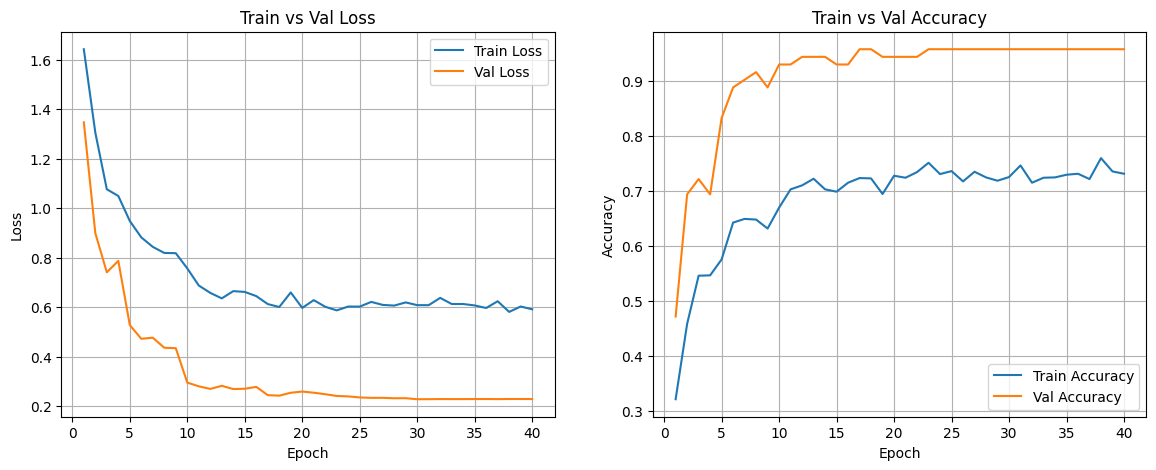

In [41]:
from matplotlib import pyplot as plt

epochs = range(1, epoch + 2)

plt.figure(figsize=(14,5))

# ---- Plot Loss ----
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_list, label="Train Loss")
plt.plot(epochs, val_losses_list, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Val Loss")
plt.legend()
plt.grid(True)

# ---- Plot Accuracy ----
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs_list, label="Train Accuracy")
plt.plot(epochs, val_accs_list, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Val Accuracy")
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
print('aloo')

In [50]:
final_model_path = "D:/Coding Projects/GitHub Projects/metal-surface-defect-classification/models/model.pth"

torch.save(model.state_dict(), final_model_path)

In [55]:
# Epochs vs Accuracy and Loss graphs

In [23]:
1656 / 32

51.75

In [30]:
len(train_loader)

52

In [31]:
10 * 52 * 32

16640

In [33]:
i = 0
for images, labels in test_loader:
    i += 1
    # images = images.to(device)
    # labels = labels.to(device)

    # print(images.shape)
    # print(labels.shape)

    print(i)
    # break

1
2
3


# Model Testing

In [63]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch

In [64]:
final_model_path = "D:/Coding Projects/GitHub Projects/metal-surface-defect-classification/models/model.pth"

In [65]:
# Loading the saved model

print(final_model_path)

model = CustomCNN(num_classes=6)
model.load_state_dict(torch.load(final_model_path, weights_only= True))
model.to(device)
model.eval()   # Set to inference mode

D:/Coding Projects/GitHub Projects/metal-surface-defect-classification/models/model.pth


CustomCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(6, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=7056, out_features=4, bias=True)
    (2): ReLU()
    (3): Linear(in_features=4, out_features=6, bias=True)
  )
)

Images covered: 72
Total test images: 72
Test Accuracy : 88.89 %


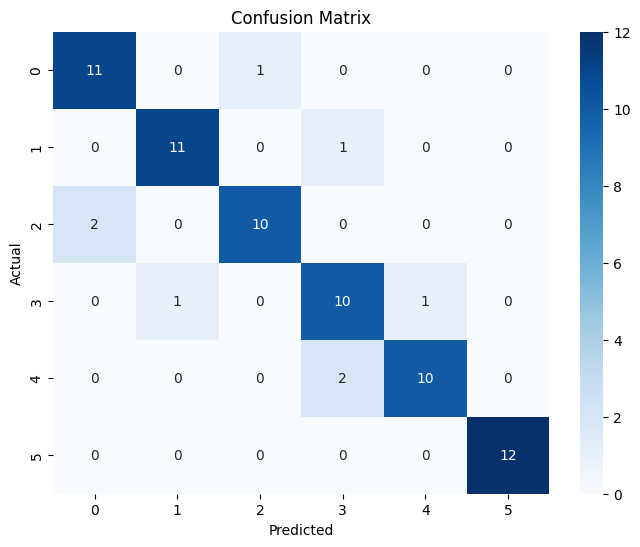

In [70]:
all_preds = []
all_labels = []

correct = 0
total = 0

total_image_count = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        total_image_count += len(labels)

        # print(images.shape)
        # print(labels.shape)

        outputs = model(images)
        _, predicted = outputs.max(1)

        # Accuracy Tracting 
        correct += (predicted ==  labels).sum().item()
        total += labels.size(0)

        # Store for Confusion Matrix
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Printing total image count
print("Images covered:", total_image_count)
print("Total test images:", len(test_dataset))

# Final Accuracy

test_acc = correct / total
print(f"Test Accuracy : {100*test_acc:.2f} %")

# Confusion matrix

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [71]:
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=train_dataset.class_to_idx.keys()))

              precision    recall  f1-score   support

     Crazing       0.85      0.92      0.88        12
   Inclusion       0.92      0.92      0.92        12
     Patches       0.91      0.83      0.87        12
      Pitted       0.77      0.83      0.80        12
      Rolled       0.91      0.83      0.87        12
   Scratches       1.00      1.00      1.00        12

    accuracy                           0.89        72
   macro avg       0.89      0.89      0.89        72
weighted avg       0.89      0.89      0.89        72



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.073294..2.64].


AttributeError: 'MetalSurfaceDataset' object has no attribute 'classes'

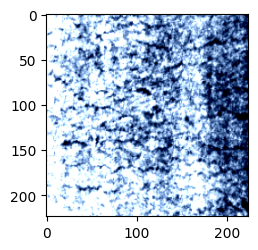

In [49]:
import matplotlib.pyplot as plt

images, labels = next(iter(test_loader))
outputs = model(images.to(device))
_, predicted = outputs.max(1)

plt.figure(figsize=(12, 8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title(f"P: {train_dataset.classes[predicted[i]]}\nT: {train_dataset.classes[labels[i]]}")
    plt.axis("off")
plt.show()

In [37]:
32 * 3

96

In [36]:
12*6

72

In [35]:
torch.no_grad()

In [34]:
with True:
    print('aloo')

AttributeError: __enter__

# Model Training

Model definition

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (2,2), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.summary()

d:\Coding Projects\GitHub Projects\metal-surface-defect-classification\env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 199, 199, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 98, 98, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 49, 49, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    18,874,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,917,734 (72.17 MB)

 Trainable params: 18,917,734 (72.17 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print('Compiled!')

Compiled!


In [21]:
callbacks = myCallback()
history = model.fit(train_generator,
        batch_size = 32,
        epochs=20,
        validation_data=validation_generator,
        callbacks=[callbacks],
        verbose=1, shuffle=True)

NameError: name 'myCallback' is not defined

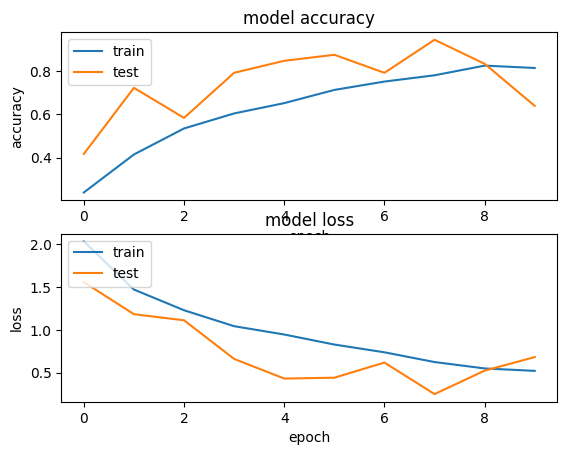

In [ ]:
plt.figure(1)  
# summarize history for accuracy  
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()


# Test Result visualization

In [ ]:
print(test_dir)

D:/Coding Projects/GitHub Projects/Metal Surface Defects Classifications/Metal-Surface-Defects-Classification/Dataset/test


In [ ]:
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
    
x_test, y_test,target_labels = load_dataset(test_dir)

In [ ]:
no_of_classes = len(np.unique(y_test))
no_of_classes

6

In [ ]:
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_test, num_classes=no_of_classes)

In [ ]:
# We just have the file names in the x set. Let's load the images and convert them into array.
from keras.preprocessing.image import array_to_img, img_to_array, load_img

def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

Test set shape :  (72, 200, 200, 3)


In [ ]:
x_test = x_test.astype('float32')/255

In [ ]:
# Let's visualize test prediction.

y_pred = model.predict(x_test)

# plot a raandom sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

NameError: name 'model' is not defined